## Predicting the sale price of bulldozers using Machine Learning

Main goal is to visualize the given time series data and predict the sale price of bulldozers. It is one of the challaenges on kaggle

### 1.Problem Definition
 Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

### 2. Data

https://www.kaggle.com/c/bluebook-for-bulldozers/data
There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

### 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

### 4. Features

Kaggle provides data dictionary for the reference
 
### 5. Modelling



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
#import training and validation data
df = pd.read_csv("data/Train.csv",low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [6]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension     

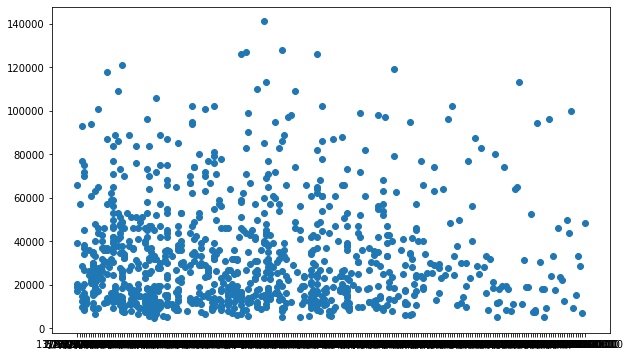

In [12]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

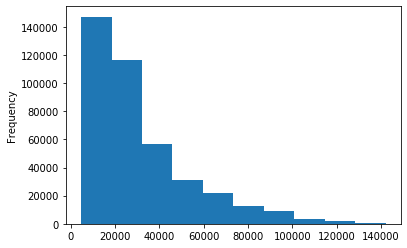

In [11]:
df.SalePrice.plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time and date componenet as much as possible .

This can be done by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [13]:
# Import the data again but now with dates parsed
df = pd.read_csv("data/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [15]:
df["saledate"][:1000]  # type of saledate is changed to datetime instead of object

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df["saledate"].head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

In [18]:
# sort dataframe by saledate. Good practice to sort when working with time series data

df.sort_values(by=["saledate"],inplace=True, ascending=True)
df["saledate"].head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [19]:
# Make a copy of the original dataframe
df_temp = df.copy()

#work on temporary dataframe and revert to original if any problem

### Add datetime parameters for `saledate` column

In [22]:
df_temp["saleyear"] = df_temp["saledate"].dt.year
df_temp["saleMonth"] = df_temp["saledate"].dt.month
df_temp["saleDay"] = df_temp["saledate"].dt.day
df_temp["saleDayOfWeek"] = df_temp["saledate"].dt.dayofweek
df_temp["saleDayOfWeek"] = df_temp["saledate"].dt.dayofyear

In [23]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [24]:
# Now drop the  sale date column
df_temp.drop("saledate",axis=1,inplace=True)

In [25]:
df_temp.state.value_counts

<bound method IndexOpsMixin.value_counts of 205615         Texas
274835       Florida
141296       Florida
212552       Florida
62755        Florida
             ...    
410879    California
412476    California
411927    California
407124    California
409203    California
Name: state, Length: 412698, dtype: object>

### Modelling


In [27]:
 # Using Random Forest Regressor
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert string into pands categories

In [28]:
# To convert string to numbers is by converting them to categories
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [29]:
pd.api.types.is_string_dtype(df_temp["UsageBand"])

True

In [30]:
## Find the columns which contains strings

for label,content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [35]:
# This will turn all of the string values into categories
for label,content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)


UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [36]:
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [38]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [39]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [40]:
df_temp.state.cat.codes     # cat  is used to access categories

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [41]:
# check missing data
df_temp.isna().sum()/len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [42]:
### Save preprocessed data
df_temp.to_csv("data/train_temp.csv",index=False)

In [44]:
df_temp = pd.read_csv("data/train_temp.csv",low_memory=False)

In [45]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,saleMonth,saleDay,saleDayOfWeek
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,31


In [46]:
# Filling the missing numerical values

In [48]:
# find numerical columns
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [49]:
# Filling the numerical rows with median
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if data was missing or not
            df_temp[label + "_is_missing"] = pd.isnull(content)
            
            # Fill missing values with median
            df_temp[label] = content.fillna(content.median())

In [50]:
# check for null numeric values
for label,content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [51]:
# Filling and turning categorical into numerical
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        
            print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [52]:
# Turn categorical into numbers and fill missing
for label,content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        
        # Add binary columns to indicate whether the sample had missing values
        df_temp[label+"_is_missing"] = pd.isnull(content)
        
        # turrn categories into numbers and add 1
        df_temp[label] = pd.Categorical(content).codes+1
        
            

In [53]:
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 102, dtype: int64

In [54]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


### Now no more missing values and data is numerical


In [58]:

# calculates time taken to execute the cell

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,random_state=42)

model.fit(df_temp.drop("SalePrice",axis=1), df_temp["SalePrice"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [59]:
model.score(df_temp.drop("SalePrice",axis=1), df_temp["SalePrice"])

0.9875586573756173

In [60]:
# This model is not reliable bcoz its tested on the same fitted data


In [61]:
# split the data into train and validation
df_val = df_temp[df_temp.saleyear == 2012]
df_train = df_temp[df_temp.saleyear != 2012]



In [64]:
# Split the data into X and Y
x_train ,y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
x_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]


In [66]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

((401125, 101), (401125,), (11573, 101), (11573,))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [68]:
model.score(x_valid,y_valid)

0.8720461568580402

In [73]:
# Building an evaluation function
from sklearn.metrics import mean_squared_log_error,mean_absolute_error

def rmsle(y_test,y_preds):
    
    """
    Calculates Root mean squared log error
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

#Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {
        "Training MAE":mean_absolute_error(y_train,train_preds),
        "Valid MAE":mean_absolute_error(y_valid,val_preds),
        "Training RMSLE":rmsle(y_train,train_preds),
        "Valid RMSLE":rmsle(y_valid,val_preds)
    }
    return scores


### Testing the model on subset( to tune hyperparameters)

In [71]:
model = RandomForestRegressor(n_jobs=-1,random_state=42,max_samples=10000)
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [74]:
show_scores(model)

{'Training MAE': 5542.612906400746,
 'Valid MAE': 7136.034564071546,
 'Training RMSLE': 0.25692943853249256,
 'Valid RMSLE': 0.2916290034800644}

In [83]:
from sklearn.model_selection import RandomizedSearchCV
# grid for RandomizedSearchCV
rf_grid = {
    "n_estimators":np.arange(10,100,10),
    "max_depth": [None,3,5,10],
    "min_samples_split":np.arange(2,20,2),
    "min_samples_leaf":np.arange(1,20,2),
    "max_features":[0.5,1,"sqrt","auto"],
    "max_samples":[10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,random_state=42),
                             param_distributions=rf_grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

rs_model.fit(x_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [85]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [86]:
show_scores(rs_model)

{'Training MAE': 10126.76806017314,
 'Valid MAE': 12330.163235165712,
 'Training RMSLE': 0.44269685569224765,
 'Valid RMSLE': 0.47863255628572177}

In [87]:
# Put n_iter =100 . Approx 2 hours to evaluate

In [90]:
%%time
# Best hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features=0.5,
                                   n_jobs=-1,
                                   max_samples=None)
ideal_model.fit(x_train,y_train)

Wall time: 58.5 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
show_scores(ideal_model)

{'Training MAE': 2965.522991906156,
 'Valid MAE': 5913.653618717756,
 'Training RMSLE': 0.14494366148257276,
 'Valid RMSLE': 0.24403961507300748}

### Predictions on test data

In [92]:
df_test = pd.read_csv("data/Test.csv")
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,5/3/2012 0:00,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,5/10/2012 0:00,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,5/10/2012 0:00,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,5/10/2012 0:00,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,5/10/2012 0:00,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Preprocessing the data

In [101]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayofweek"] = df["saledate"].dt.dayofweek
    df["saleDayofyear"] = df["saledate"].dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df